# Load modules

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load dataset from shared Google Drive

In [ ]:
fusion = pd.read_csv('/content/drive/Shareddrives/Data322/phase_data_with_stability.csv') # assuming you've mounted your Google Drive to your Colab session
# fusion = pd.read_csv("G:\Shared drives\Data322\phase_data_with_stability.csv")  # school computer, assuming you've logged into your Google Drive

In [ ]:
fusion.describe()

,time_step,particle_index,position,velocity,is_unstable
count,5.901000e+07,5.901000e+07,5.901000e+07,5.901000e+07,5.901000e+07
mean,2.551410e+02,4.999500e+03,2.003580e+02,2.542267e-03,2.645314e-01
std,1.438111e+02,2.886751e+03,1.155504e+02,1.780696e+00,4.410834e-01
min,0.000000e+00,0.000000e+00,8.878719e-08,-8.282767e+00,0.000000e+00
25%,1.330000e+02,2.499750e+03,1.003288e+02,-1.175960e+00,0.000000e+00
50%,2.580000e+02,4.999500e+03,2.006574e+02,8.457956e-04,0.000000e+00
75%,3.740000e+02,7.499250e+03,3.001207e+02,1.177338e+00,1.000000e+00
max,5.000000e+02,9.999000e+03,4.000000e+02,7.691032e+00,1.000000e+00


# Check dataset
Let's check that the dataset has the structure I'm expecting.

In [ ]:
# Count the number of unique folder_names in the fusion dataset
unique_folders = fusion['folder_name'].nunique()
print(f"Number of unique folder_names: {unique_folders}")

# Display the unique folder names
print("\nUnique folder names:")
print(fusion['folder_name'].unique())




Number of unique folder_names: 13

Unique folder names:
['v0_0' 'v0_2' 'v0_4' 'v0_6' 'v0_8' 'v1_0' 'v1_2' 'v1_4' 'v1_8' 'v2_0'
 'v2_2' 'v2_4' 'v2_6']


In [ ]:
# Count the number of unique particles for each folder_name
particles_per_folder = fusion.groupby('folder_name')['particle_index'].nunique()

# Display the results
print("Number of unique particles per folder:")
print(particles_per_folder)

Number of unique particles per folder:
folder_name
v0_0    10000
v0_2    10000
v0_4    10000
v0_6    10000
v0_8    10000
v1_0    10000
v1_2    10000
v1_4    10000
v1_8    10000
v2_0    10000
v2_2    10000
v2_4    10000
v2_6    10000
Name: particle_index, dtype: int64


In [ ]:
# Count the number of time points for one particle for each folder_name
# First, let's select one particle from each folder (particle_index = 0)
one_particle_per_folder = fusion[fusion['particle_index'] == 0]

# Now count the number of time points for this particle in each folder
time_points_per_folder = one_particle_per_folder.groupby('folder_name')['time_step'].nunique()

# Get min and max time points for each folder
min_time_per_folder = fusion.groupby('folder_name')['time_step'].min()
max_time_per_folder = fusion.groupby('folder_name')['time_step'].max()

# Find the first time point where instability occurs for each folder
first_unstable_time = fusion[fusion['is_unstable'] == 1].groupby('folder_name')['time_step'].min()

# Create a DataFrame to display all the information
folder_stats = pd.DataFrame({
    'num_time_pts': time_points_per_folder,
    'min_time_pt': min_time_per_folder,
    'max_time_pt': max_time_per_folder,
    'first_unstable_time': first_unstable_time
})

# Display the results
print("Statistics for each folder:")
print(folder_stats)


Statistics for each folder:
             num_time_pts  min_time_pt  max_time_pt  first_unstable_time
folder_name                                                             
v0_0                  501            0          500                  NaN
v0_2                  501            0          500                  NaN
v0_4                  501            0          500                  NaN
v0_6                  501            0          500                  NaN
v0_8                  501            0          500                  NaN
v1_0                  501            0          500                  NaN
v1_2                  501            0          500                  NaN
v1_4                  438            0          500                  NaN
v1_8                  346           86          500                300.0
v2_0                  460            0          500                 55.0
v2_2                  148          282          500                375.0
v2_4                  5

Notice that there are 10,000 particles per folder, there are 13 folders with between 148 and 501 timepoints each. Of these 13 folders, 8 folders are always stable and 5 become unstable at various times, ranging from 53 to 375.  The project instructions said to remove v2_2 from the dataset so I'll do that next:

# Remove data from folder v2_2

In [ ]:
# Remove all rows for folder_name v2_2 from the fusion dataset
print(f"Shape of fusion dataset before removing v2_2: {fusion.shape}")
fusion = fusion[fusion['folder_name'] != 'v2_2']
print(f"Shape of fusion dataset after removing v2_2: {fusion.shape}")

# Verify that v2_2 is no longer in the dataset
remaining_folders = fusion['folder_name'].unique()
print(f"Remaining folders: {remaining_folders}")
print(f"Number of remaining folders: {len(remaining_folders)}")


Shape of fusion dataset before removing v2_2: (59010000, 6)
Shape of fusion dataset after removing v2_2: (57530000, 6)
Remaining folders: ['v0_0' 'v0_2' 'v0_4' 'v0_6' 'v0_8' 'v1_0' 'v1_2' 'v1_4' 'v1_8' 'v2_0'
 'v2_4' 'v2_6']
Number of remaining folders: 12


# New label to predict a future instability

Create a new label so I can predict instability before it happens.  I'll create a label of instability 3 time-steps before it happens

In [ ]:
fusion.sort_values(by=['folder_name', 'particle_index', 'time_step'], inplace=True)

# 2. Apply shift within each group of (folder_name, particle_index).
#    The .groupby(['folder_name', 'particle_index']) ensures shift operates
#    independently for each particle's time series within each folder.
#    shift(-1) looks at the next time_step's 'is_unstable' value for that specific particle.
fusion['is_unstable_in_3points'] = fusion.groupby(['folder_name', 'particle_index'])['is_unstable'].shift(-3, fill_value=0).astype(int)


In [ ]:
# Find the first time point where is_unstable_in_3points occurs for each folder
first_unstable_in_3_time = fusion[fusion['is_unstable_in_3points'] == 1].groupby('folder_name')['time_step'].min()

# Create an updated DataFrame with the new information
folder_stats_updated = pd.DataFrame({
    'min_time_pt': min_time_per_folder[min_time_per_folder.index != 'v2_2'],
    'max_time_pt': max_time_per_folder[max_time_per_folder.index != 'v2_2'],
    'first_unstable': first_unstable_time[first_unstable_time.index != 'v2_2'],
    'first_unstable_in_3': first_unstable_in_3_time
})

# Display the updated results
print("\nUpdated statistics for each folder (after removing v2_2):")
print(folder_stats_updated)


Updated statistics for each folder (after removing v2_2):
             min_time_pt  max_time_pt  first_unstable  first_unstable_in_3
folder_name                                                               
v0_0                   0          500             NaN                  NaN
v0_2                   0          500             NaN                  NaN
v0_4                   0          500             NaN                  NaN
v0_6                   0          500             NaN                  NaN
v0_8                   0          500             NaN                  NaN
v1_0                   0          500             NaN                  NaN
v1_2                   0          500             NaN                  NaN
v1_4                   0          500             NaN                  NaN
v1_8                  86          500           300.0                297.0
v2_0                   0          500            55.0                 52.0
v2_4                   0          500    

I'll check a graph of the instability starting time and average velocity for all folders

<ipython-input-10-378f2823ea0b>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(folders))


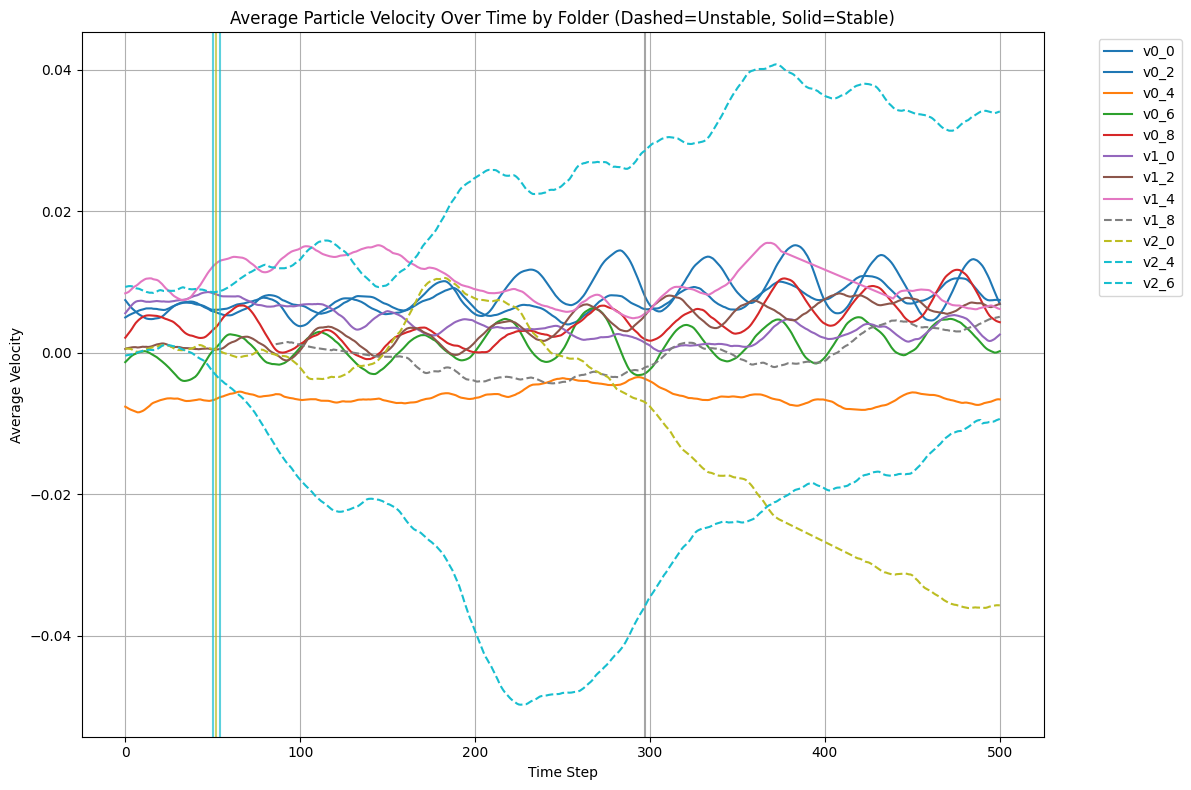

In [ ]:
# Calculate average velocity for each time_step and folder_name
avg_velocity_by_folder = fusion.groupby(['folder_name', 'time_step'])['velocity'].mean().reset_index()

# Create a plot of time_step vs average velocity for each folder
plt.figure(figsize=(12, 8))

# Get unique folder names (excluding v2_2 which was removed)
folders = [folder for folder in fusion['folder_name'].unique() if folder != 'v2_2']

# Create a colormap for the folders
import matplotlib.cm as cm
import matplotlib.colors as mcolors
cmap = cm.get_cmap('tab10', len(folders))
folder_colors = {folder: mcolors.rgb2hex(cmap(i)) for i, folder in enumerate(folders)}

# Plot a line for each folder
for folder in folders:
    folder_data = avg_velocity_by_folder[avg_velocity_by_folder['folder_name'] == folder]

    # Check if instability occurs in this folder
    has_instability = folder in first_unstable_time.index and not pd.isna(first_unstable_time[folder])

    # Use folder-specific color and line style based on instability
    color = folder_colors[folder]
    linestyle = '--' if has_instability else '-'

    plt.plot(folder_data['time_step'], folder_data['velocity'],
             label=folder, color=color, linestyle=linestyle)

    # Add vertical line at first_unstable_in_3 if it exists
    if folder in first_unstable_in_3_time.index and not pd.isna(first_unstable_in_3_time[folder]):
        plt.axvline(x=first_unstable_in_3_time[folder], color=color,
                   alpha=0.7, label=f'{folder} unstable in 3' if folder == folders[0] else "")

plt.title('Average Particle Velocity Over Time by Folder (Dashed=Unstable, Solid=Stable)')
plt.xlabel('Time Step')
plt.ylabel('Average Velocity')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

def plot_folder_particles(folder_name):
    """
    Create a line plot for a specific folder showing particle positions over time.

    Parameters:
    folder_name (str): The name of the folder to plot (e.g., 'v0_0')
    """
    # Filter data for the specified folder
    folder_data = fusion[fusion['folder_name'] == folder_name]

    if folder_data.empty:
        print(f"No data found for folder {folder_name}")
        return

    # Create figure with two subplots - one for positions, one for velocities
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Get the first time step where instability occurs in this folder
    first_unstable = None
    if folder_name in first_unstable_time.index and not pd.isna(first_unstable_time[folder_name]):
        first_unstable = first_unstable_time[folder_name]

    # Normalize velocities for color intensity
    max_vel = folder_data['velocity'].abs().max()
    folder_data['normalized_vel'] = folder_data['velocity'].abs() / max_vel

    # Get unique particle indices
    particle_indices = folder_data['particle_index'].unique()

    # Sample a subset of particles if there are too many
    max_particles_to_plot = 100
    if len(particle_indices) > max_particles_to_plot:
        particle_indices = np.random.choice(particle_indices, max_particles_to_plot, replace=False)

    # Create a colormap
    cmap = plt.cm.coolwarm

    # Plot each particle's trajectory
    for particle_idx in particle_indices:
        particle_data = folder_data[folder_data['particle_index'] == particle_idx]

        # Sort by time step to ensure proper line connection
        particle_data = particle_data.sort_values('time_step')

        # Use velocity to determine line color
        avg_velocity = particle_data['velocity'].mean()
        normalized_vel = abs(avg_velocity) / max_vel if max_vel > 0 else 0
        color = cmap(0.5 + 0.5 * np.sign(avg_velocity))

        # Plot position over time
        ax1.plot(particle_data['time_step'], particle_data['position'],
                 linewidth=1, alpha=0.7, color=color)

        # Plot velocity over time
        ax2.plot(particle_data['time_step'], particle_data['velocity'],
                 linewidth=1, alpha=0.7, color=color)

    # Add vertical line at first instability if it exists
    if first_unstable is not None:
        ax1.axvline(x=first_unstable, color='red', linestyle='--',
                   linewidth=2, label=f'First instability at t={first_unstable}')
        ax2.axvline(x=first_unstable, color='red', linestyle='--',
                   linewidth=2)

    # Set titles and labels
    ax1.set_title(f'Particle Positions Over Time for {folder_name}')
    ax1.set_ylabel('Position')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    ax2.set_title('Particle Velocities')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Velocity')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


<ipython-input-11-f807c787c256>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  folder_data['normalized_vel'] = folder_data['velocity'].abs() / max_vel


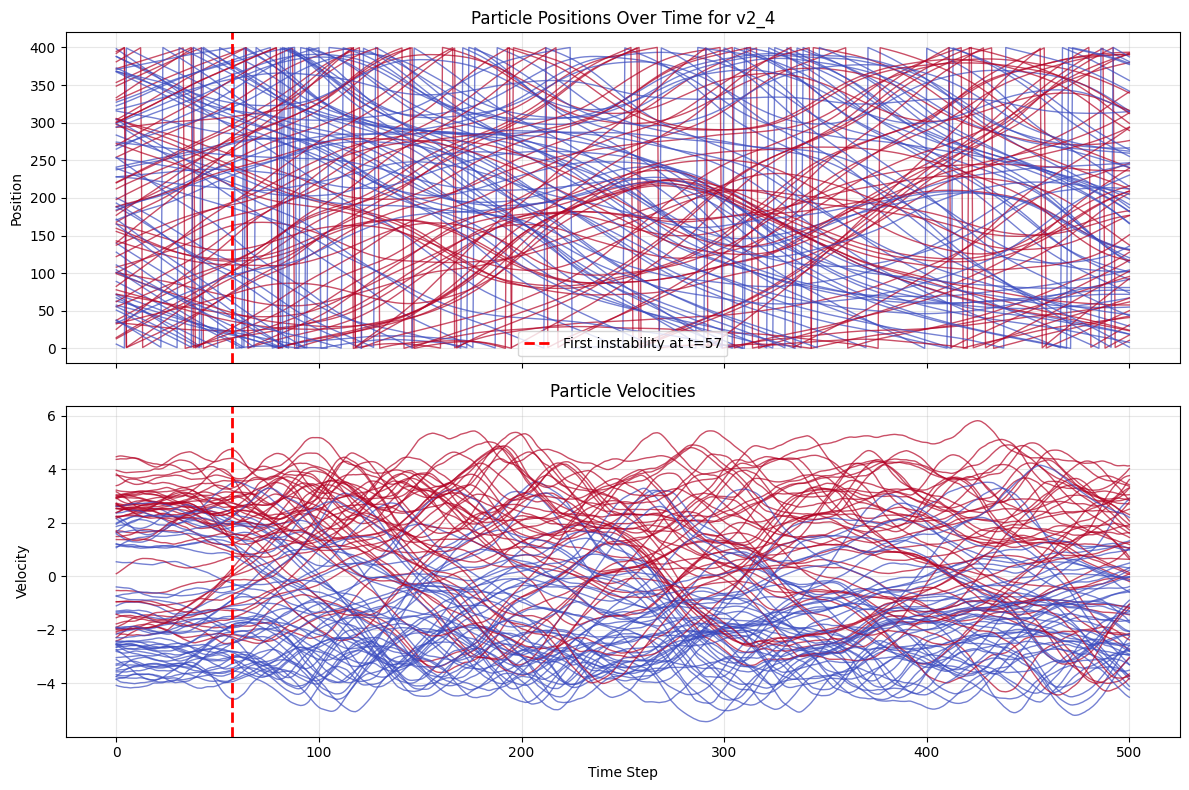

In [ ]:
plot_folder_particles('v2_4')

Will be updated to relflect more accuracy.
Predicting to much at once will need ot be changed to one particle

In [ ]:
# Split data into train and test sets for cross-validation
import numpy as np
from sklearn.model_selection import KFold

# Define the actual folder names
all_folders = ['v0_0', 'v0_2', 'v0_4', 'v0_6',
               'v1_0', 'v1_2', 'v1_4', 'v1_6',
               'v2_0', 'v2_4', 'v2_6']


total_folders = len(all_folders)
n_splits = 3

# Use KFold for cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Display the fold splits
print(f"Using {n_splits}-fold cross-validation:")
for fold, (train_idx, test_idx) in enumerate(kf.split(all_folders)):
    train_folders = [all_folders[i] for i in train_idx]
    test_folders = [all_folders[i] for i in test_idx]

    print(f"\nFold {fold+1}:")
    print(f"  Training folders ({len(train_folders)}): {', '.join(train_folders)}")
    print(f"  Test folders ({len(test_folders)}): {', '.join(test_folders)}")

    # Check if this fold has approximately 4 folders in the test set
    if len(test_folders) == 4 or abs(len(test_folders) - 4) <= 1:
        print(f"  ✓ This fold has {len(test_folders)} folders in the test set")




Using 3-fold cross-validation:

Fold 1:
  Training folders (7): v0_2, v0_4, v0_6, v1_0, v1_4, v1_6, v2_0
  Test folders (4): v0_0, v1_2, v2_4, v2_6
  ✓ This fold has 4 folders in the test set

Fold 2:
  Training folders (7): v0_0, v0_6, v1_2, v1_4, v1_6, v2_4, v2_6
  Test folders (4): v0_2, v0_4, v1_0, v2_0
  ✓ This fold has 4 folders in the test set

Fold 3:
  Training folders (8): v0_0, v0_2, v0_4, v1_0, v1_2, v2_0, v2_4, v2_6
  Test folders (3): v0_6, v1_4, v1_6
  ✓ This fold has 3 folders in the test set


Using folder 'v2_6' with first instability at t=53.0


<ipython-input-14-b13dfc17acfe>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_folder_data['time_since_start'] = single_folder_data['time_step'] - single_folder_data['time_step'].min()
<ipython-input-14-b13dfc17acfe>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_folder_data['velocity_diff'] = single_folder_data.groupby('particle_index')['velocity'].diff().fillna(0)



Classification Report:
              precision    recall  f1-score   support

      Stable       1.00      1.00      1.00    159000
    Unstable       1.00      1.00      1.00   1344000

    accuracy                           1.00   1503000
   macro avg       1.00      1.00      1.00   1503000
weighted avg       1.00      1.00      1.00   1503000



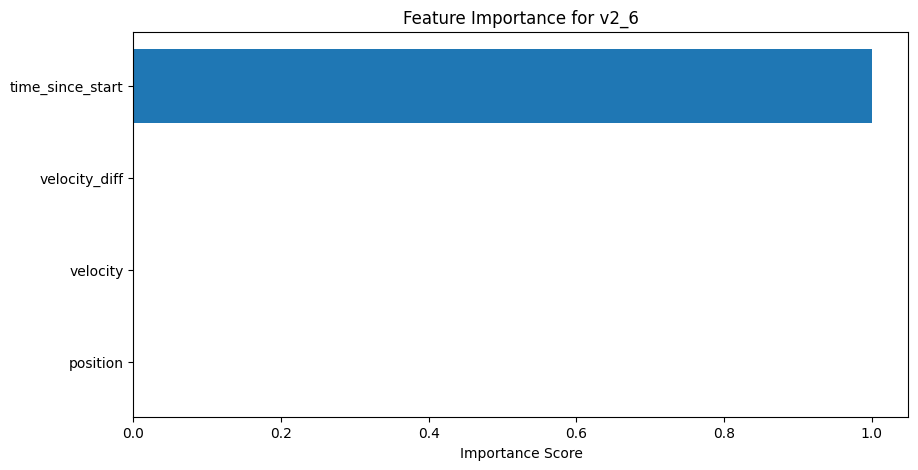

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


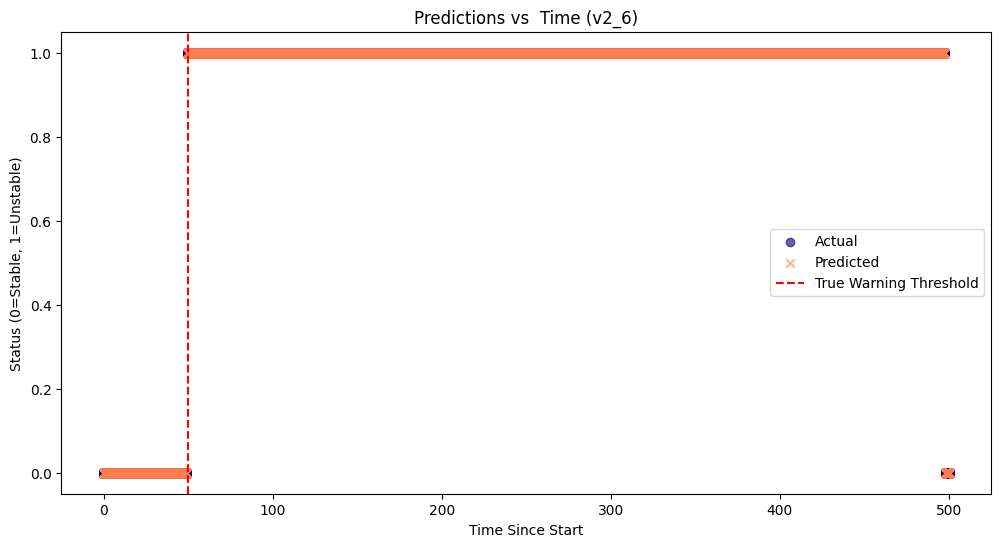

In [ ]:
# Get first instability times for all folders
first_unstable_times = folder_stats_updated['first_unstable'].dropna()

# Find folder with the earliest instability
target_folder = first_unstable_times.idxmin()
first_unstable_time = first_unstable_times.min()

print(f"Using folder '{target_folder}' with first instability at t={first_unstable_time}")

# Filter dataset
single_folder_data = fusion[fusion['folder_name'] == target_folder]

# Feature engineering
single_folder_data['time_since_start'] = single_folder_data['time_step'] - single_folder_data['time_step'].min()
single_folder_data['velocity_diff'] = single_folder_data.groupby('particle_index')['velocity'].diff().fillna(0)

#features and target
X = single_folder_data[['position', 'velocity', 'time_since_start', 'velocity_diff']]
y = single_folder_data['is_unstable_in_3points']

# Split within one folder
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

# Train DT
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(
    max_depth=4,
    min_samples_split=50,  # Higher due to smaller dataset
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Stable', 'Unstable']))

# Feature Importance Visualization
plt.figure(figsize=(10, 5))
plt.barh(X.columns[np.argsort(model.feature_importances_)],
         model.feature_importances_[np.argsort(model.feature_importances_)])
plt.title(f'Feature Importance for {target_folder}')
plt.xlabel('Importance Score')
plt.show()

# Time-based Performance Analysis
test_data_with_pred = X_test.copy()
test_data_with_pred['actual'] = y_test
test_data_with_pred['predicted'] = y_pred

# Plot predictions vs actual over time
plt.figure(figsize=(12, 6))
plt.scatter(test_data_with_pred['time_since_start'], test_data_with_pred['actual'],
            label='Actual', alpha=0.6, color='navy')
plt.scatter(test_data_with_pred['time_since_start'], test_data_with_pred['predicted'],
            label='Predicted', alpha=0.6, color='coral', marker='x')
plt.axvline(x=first_unstable_time-3, color='red', linestyle='--',
           label='True Warning Threshold')
plt.title(f'Predictions vs  Time ({target_folder})')
plt.xlabel('Time Since Start')
plt.ylabel('Status (0=Stable, 1=Unstable)')
plt.legend()
plt.show()

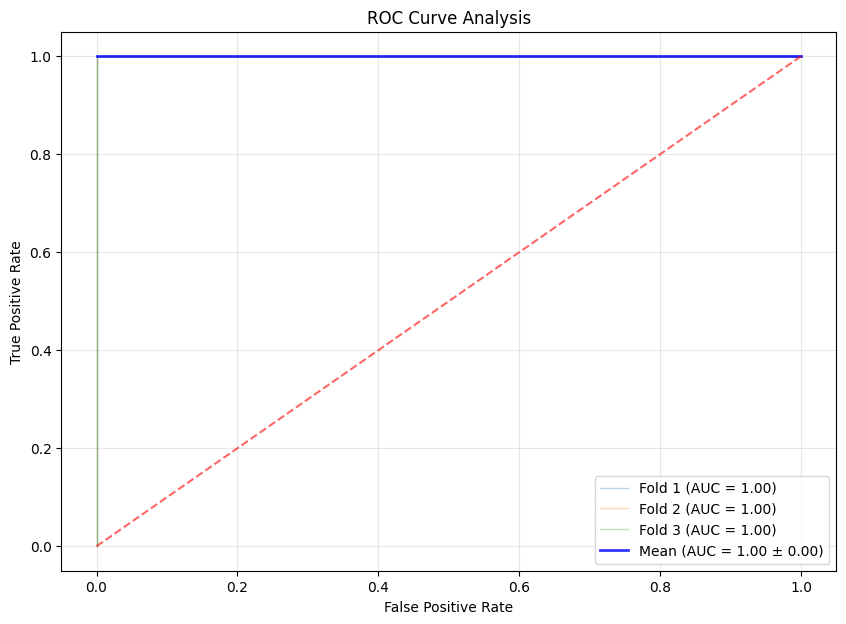

In [ ]:
# ROC/AUC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

# Cross-validation loop
for fold, (train_idx, test_idx) in enumerate(kf.split(train_folders)):
    # ... [your existing data splitting code] ...

    # Get probabilities only (no class predictions)
    y_pr = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(np.interp(mean_fpr, fpr, tpr))
    aucs.append(roc_auc)

    plt.plot(fpr, tpr, alpha=0.3, lw=1,
             label=f'Fold {fold+1} (AUC = {roc_auc:.2f})')

# Mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=f'Mean (AUC = {mean_auc:.2f} ± {np.std(aucs):.2f})',
         lw=2, alpha=0.8)

plt.plot([0, 1], [0, 1], linestyle='--', color='r', alpha=0.6)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Analysis')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
#  Confusion Matrix
aggregated_cm = np.sum(all_confusion_matrices, axis=0)
tn, fp, fn, tp = aggregated_cm.ravel()

print("\nAggregated Confusion Matrix:")
print(f"[[{tn:>6}  {fp:>6}]")
print(f" [{fn:>6}  {tp:>6}]]")

print("\nClassification Totals:")
print(f"{'True Negatives:':<15} {tn:>6}")
print(f"{'False Positives:':<15} {fp:>6}")
print(f"{'False Negatives:':<15} {fn:>6}")
print(f"{'True Positives:':<15} {tp:>6}")
print(f"\nTotal Samples: {tn + fp + fn + tp}")


Aggregated Confusion Matrix:
[[477000       0]
 [     0  4032000]]

Classification Totals:
True Negatives: 477000
False Positives:      0
False Negatives:      0
True Positives: 4032000

Total Samples: 4509000
